In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
img = cv2.imread("./data/faces93")


In [3]:
from tqdm import tqdm

image_data = []
photos_path= "./data/faces94"
for folder in os.listdir(photos_path):
    print("going through folders")
    inside_folder_path = os.path.join(photos_path, folder)
    for images_folder in tqdm(os.listdir(inside_folder_path)):
        images_folder_path = os.path.join(inside_folder_path, images_folder)
        for image_file in filter(lambda x: x.endswith("jpg"), os.listdir(images_folder_path)):
            image_file_path = os.path.join(images_folder_path, image_file)
            image = cv2.imread(image_file_path)
            image_data.append({'Filename': image_file_path, 'ImageArray': image})

print("Created the dataframe")

going through folders


100%|██████████| 20/20 [00:01<00:00, 11.08it/s]


going through folders


100%|██████████| 113/113 [00:11<00:00, 10.22it/s]


going through folders


100%|██████████| 20/20 [00:01<00:00, 10.60it/s]

Created the dataframe


In [4]:
images = list(map(lambda item: item["ImageArray"], image_data))
files_path = list(map(lambda item: item["Filename"], image_data))
images = np.array(images)

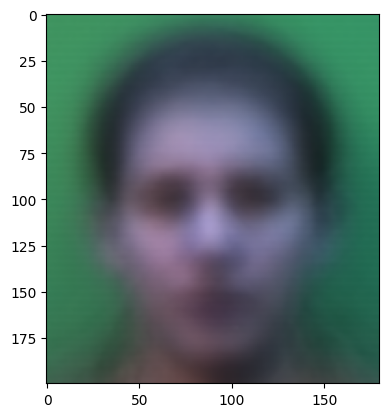

In [5]:
average_image = images.mean(axis=0)
average_image = np.round(average_image)
average_image = average_image.astype(np.uint8)
plt.imshow(average_image)

In [47]:
images_vectors = (images - average_image).reshape(images.shape[0], -1) # Normalizing images
N = images_vectors.shape[0]
images_vectors.shape # The shape is now mxn (m=number of photos, n=photo vector length (rxc))

(3059, 108000)

Denote covariance matrix as S.  
$S = TT^T$  
$ Sv_i = TT^Tv_i = \lambda _iv_i $  
But $TT^T$ is a very large matrix, and calculating it is not feasible


In [7]:

# Compute the covariance matrix of the vectors
cov_matrix = np.cov(images_vectors) # covariance of m x m (m = number of rows)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [8]:
# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [14]:
eignevector = eigenvectors[0]
T = images_vectors.T
eigenface = np.dot(T, eignevector)

In [42]:
eigenface

array([350.53677711+0.00035786j, 224.40082707-0.00141312j,
       284.1228879 -0.00108755j, ..., 105.28296964+0.07863024j,
       222.47154107-0.00500134j, 256.03349526-0.00507292j])

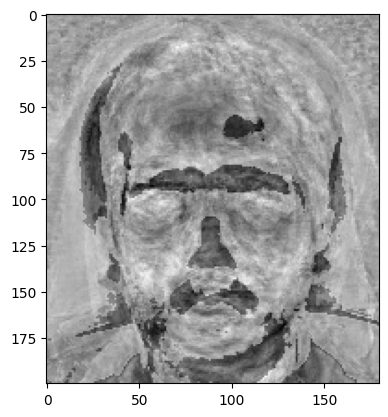

In [52]:
eigenface_image = eigenface.real.reshape(average_image.shape)
# eigenface_image = eigenface_image / N
eigenface_image = (eigenface_image - eigenface_image.min()) / (eigenface_image.max() - eigenface_image.min())
eigenface_image = eigenface_image * 255
eigenface_image = eigenface_image.astype(np.uint8)
eigenface_image = cv2.cvtColor(eigenface_image, cv2.COLOR_BGR2GRAY)
plt.imshow(eigenface_image, cmap='gray')

In [6]:
images_vectors_raw = images.reshape(images.shape[0], -1)
average_image = images.reshape(images.shape[0],-1).mean(axis=0)
# X = (images - average_image).reshape(images.shape[0], -1)
X = images_vectors_raw - average_image

# both of size (NxD)

In [14]:
N = images.shape[0]

In [7]:
cov_matrix = np.cov(images_vectors_raw)

In [23]:
import scipy

In [35]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(cov_matrix, k=100)

In [36]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [37]:
eigenvectors.shape

(3059, 100)

In [ ]:
for idx in range(10):
    eigenvector = eigenvectors[:,idx]
    normalization_factor = np.sqrt(eigenvalues[idx] * N)
    eigenface1 = np.dot(X.T , eigenvector) /  normalization_factor
    eigenface_image = eigenface1.reshape(images[0].shape)
    eigenface_image = (eigenface_image - eigenface_image.min()) / (eigenface_image.max() - eigenface_image.min())
    eigenface_image = eigenface_image * 255
    eigenface_image = eigenface_image.astype(np.uint8)
    eigenface_image = cv2.cvtColor(eigenface_image, cv2.COLOR_BGR2GRAY)
    plt.imshow(eigenface_image, cmap='gray')
    plt.show()